In [1]:
import pandas as pd
df = pd.read_csv("https://theunitedstates.io/congress-legislators/legislators-current.csv")
df.head() 

,last_name,first_name,middle_name,suffix,nickname,full_name,birthday,gender,type,state,district,senate_class,party,url,address,phone,contact_form,rss_url,twitter,facebook,youtube,youtube_id,bioguide_id,thomas_id,opensecrets_id,lis_id,fec_ids,cspan_id,govtrack_id,votesmart_id,ballotpedia_id,washington_post_id,icpsr_id,wikipedia_id
0,Brown,Sherrod,NaN,NaN,NaN,Sherrod Brown,1952-11-09,M,sen,OH,NaN,1.0,Democrat,https://www.brown.senate.gov,503 Hart Senate Office Building Washington DC ...,202-224-2315,http://www.brown.senate.gov/contact/,http://www.brown.senate.gov/rss/feeds/?type=al...,SenSherrodBrown,SenatorSherrodBrown,SherrodBrownOhio,UCgy8jfERh-t_ixkKKoCmglQ,B000944,136.0,N00003535,S307,"H2OH13033,S6OH00163",5051.0,400050,27018.0,Sherrod Brown,NaN,29389.0,Sherrod Brown
1,Cantwell,Maria,NaN,NaN,NaN,Maria Cantwell,1958-10-13,F,sen,WA,NaN,1.0,Democrat,https://www.cantwell.senate.gov,511 Hart Senate Office Building Washington DC ...,202-224-3441,http://www.cantwell.senate.gov/public/index.cf...,http://www.cantwell.senate.gov/public/index.cf...,SenatorCantwell,senatorcantwell,SenatorCantwell,UCN52UDqKgvHRk39ncySrIMw,C000127,172.0,N00007836,S275,"S8WA00194,H2WA01054",26137.0,300018,27122.0,Maria Cantwell,NaN,39310.0,Maria Cantwell
2,Cardin,Benjamin,L.,NaN,NaN,Benjamin L. Cardin,1943-10-05,M,sen,MD,NaN,1.0,Democrat,https://www.cardin.senate.gov,509 Hart Senate Office Building Washington DC ...,202-224-4524,http://www.cardin.senate.gov/contact/,http://www.cardin.senate.gov/rss/feeds/?type=all,SenatorCardin,senatorbencardin,senatorcardin,UCiQaJnMzlfzzG3VESgyZChA,C000141,174.0,N00001955,S308,"H6MD03177,S6MD03177",4004.0,400064,26888.0,Ben Cardin,NaN,15408.0,Ben Cardin
3,Carper,Thomas,Richard,NaN,NaN,Thomas R. Carper,1947-01-23,M,sen,DE,NaN,1.0,Democrat,https://www.carper.senate.gov/public,513 Hart Senate Office Building Washington DC ...,202-224-2441,http://www.carper.senate.gov/public/index.cfm/...,http://www.carper.senate.gov/public/index.cfm/...,SenatorCarper,tomcarper,senatorcarper,UCgLnvbKwu4B3navofj6Qvvw,C000174,179.0,N00012508,S277,S8DE00079,663.0,300019,22421.0,Tom Carper,NaN,15015.0,Tom Carper
4,Casey,Robert,P.,Jr.,Bob,"Robert P. Casey, Jr.",1960-04-13,M,sen,PA,NaN,1.0,Democrat,https://www.casey.senate.gov,393 Russell Senate Office Building Washington ...,202-224-6324,https://www.casey.senate.gov/contact/,http://www.casey.senate.gov/rss/feeds/?all,SenBobCasey,SenatorBobCasey,SenatorBobCasey,UCtVssXhx-KuZa-hSvnsnJ0A,C001070,1828.0,N00027503,S309,S6PA00217,47036.0,412246,2541.0,"Bob Casey, Jr.",NaN,40703.0,Bob Casey Jr.


In [ ]:
# https://drive.google.com/file/d/1-26HtaU6_PfJm-FizHSgJpUh_KRPO60S/view 
# https://colab.research.google.com/drive/1Q4vHa44H8Nly7m4J8YFReA75tL95994D?usp=sharing 
# downloaded images from legislators and used mtcnn to crop the faces

In [7]:
!unzip drive/MyDrive/faces/faces.zip
#!ls drive/MyDrive/faces/

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: faces/antonio_delgado/0_face_16.antonio_delgado_apfilejpg.jpg  
  inflating: faces/antonio_delgado/0_face_2.imkyeto0_400x400.jpg  
  inflating: faces/antonio_delgado/0_face_20.44920421_634056873657629_211051553304346624_n.jpg  
  inflating: faces/antonio_delgado/0_face_15.screen_shot_2018_07_18_at_9.23.24_am.0.png.jpg  
  inflating: faces/antonio_delgado/3_face_25.70b8abf6168d2345-1495034871082.jpg  
  inflating: faces/antonio_delgado/1_face_17.180511_antonio_delgado_0725-1145x700.jpg  
  inflating: faces/antonio_delgado/0_face_17.180511_antonio_delgado_0725-1145x700.jpg  
  inflating: faces/antonio_delgado/7_face_23.img_0105.jpeg  
  inflating: faces/antonio_delgado/1_face_13.delgado-e1541470468313-1024x640.jpg  
  inflating: faces/antonio_delgado/3_face_21.im-245737.jpg  
  inflating: faces/antonio_delgado/0_face_10.img_8096.jpg  
  inflating: faces/antonio_delgado/0_face_29.02faso-delgado1-articlelarge-v2.jpg  


In [10]:
import glob
import random
import matplotlib.pyplot as plt

# Get a list of all files
filenames = glob.glob("faces/**/*")

filenames

['faces/julia_brownley/0_face_27.d8ec03fa-5808-4320-a6e0-65ca6c606b35-julia_brownley_usps_1.jpg',
 'faces/julia_brownley/1_face_17.rk-jb-lwv.jpg',
 'faces/julia_brownley/0_face_23.d2wdyg7xcaagyrj.jpg',
 'faces/julia_brownley/0_face_3.brownley_1.jpg',
 'faces/julia_brownley/1_face_21.john_lewis_and_julia_brownley_-_2020-03-04.jpg',
 'faces/julia_brownley/2_face_21.john_lewis_and_julia_brownley_-_2020-03-04.jpg',
 'faces/julia_brownley/0_face_11.ldn-l-elx-cong-web-26-11071-1.jpg',
 'faces/julia_brownley/0_face_25.annie_sun.jpg',
 'faces/julia_brownley/0_face_29.c9z1plaxsaarsot.jpg',
 'faces/julia_brownley/1_face_30.gctd-morehousebrownley.jpg',
 'faces/julia_brownley/2_face_23.d2wdyg7xcaagyrj.jpg',
 'faces/julia_brownley/0_face_21.john_lewis_and_julia_brownley_-_2020-03-04.jpg',
 'faces/julia_brownley/1_face_19.1167365a-9629-49f2-b864-2f954d0152bd-election_2020_congress_26th_district-updated.jpg',
 'faces/julia_brownley/3_face_28.mc-124-brownley-visits-alcoa.jpg',
 'faces/julia_brownley/0

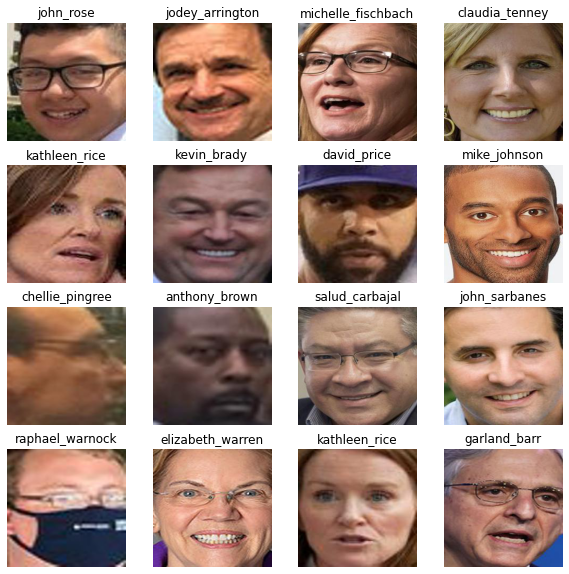

In [11]:
# Let's look at them!!!
plt.figure(figsize=(10, 10))
for i, filename in enumerate(random.sample(filenames, 16)):
  ax = plt.subplot(4, 4, i + 1)
  img = plt.imread(filename)
  plt.imshow(img)
  plt.title(filename.split("/")[1])
  plt.axis("off") 

In [12]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt 

In [13]:
# Magic numbers for success
IMAGE_SIZE = (224, 224)
IMAGE_SHAPE = IMAGE_SIZE + (3,) 

In [14]:
# Magic code for success
data_dir = 'faces'
datagen_kwargs = dict(rescale=1./255, validation_split=.10)
dataflow_kwargs = dict(target_size=IMAGE_SIZE, interpolation="bilinear", class_mode='sparse')

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
data_dir, subset="validation", shuffle=False, **dataflow_kwargs)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
rotation_range=5,
horizontal_flip=True,
width_shift_range=0.2, height_shift_range=0.2,
shear_range=0.2, zoom_range=0.2,
**datagen_kwargs)

train_generator = train_datagen.flow_from_directory(
data_dir, subset="training", shuffle=True, **dataflow_kwargs) 

Found 2777 images belonging to 536 classes.
Found 27391 images belonging to 536 classes.


In [15]:
base_model_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4"

# download the model from 
pretrained_model = hub.KerasLayer(base_model_url, trainable=False)

model = tf.keras.Sequential([
tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
pretrained_model,
tf.keras.layers.Dropout(rate=0.2),
tf.keras.layers.Dense(train_generator.num_classes,
activation='softmax')
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 536)               686616    
Total params: 2,944,600
Trainable params: 686,616
Non-trainable params: 2,257,984
_________________________________________________________________


In [16]:
model.compile(
optimizer='adam', 
loss=tf.keras.losses.SparseCategoricalCrossentropy(),
metrics=['accuracy']) 

In [17]:
num_epochs = 3

# This is a little more complicated than in class because we
# are using that 'flow' loader instead of the 'images' loader
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size
model.fit(
train_generator,
epochs=num_epochs,
steps_per_epoch=steps_per_epoch,
validation_data=valid_generator,
validation_steps=validation_steps) 

Epoch 1/3


KeyboardInterrupt: ignored

In [18]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Activation, Input, Add, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Concatenate, Lambda, add, GlobalAveragePooling2D, Convolution2D, LocallyConnected2D, ZeroPadding2D, concatenate, AveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K


def scaling(x, scale):
	return x * scale

def InceptionResNetV2():
	inputs = Input(shape=(160, 160, 3))
	x = Conv2D(32, 3, strides=2, padding='valid', use_bias=False, name= 'Conv2d_1a_3x3') (inputs)
	x = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Conv2d_1a_3x3_BatchNorm')(x)
	x = Activation('relu', name='Conv2d_1a_3x3_Activation')(x)
	x = Conv2D(32, 3, strides=1, padding='valid', use_bias=False, name= 'Conv2d_2a_3x3') (x)
	x = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Conv2d_2a_3x3_BatchNorm')(x)
	x = Activation('relu', name='Conv2d_2a_3x3_Activation')(x)
	x = Conv2D(64, 3, strides=1, padding='same', use_bias=False, name= 'Conv2d_2b_3x3') (x)
	x = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Conv2d_2b_3x3_BatchNorm')(x)
	x = Activation('relu', name='Conv2d_2b_3x3_Activation')(x)
	x = MaxPooling2D(3, strides=2, name='MaxPool_3a_3x3')(x)
	x = Conv2D(80, 1, strides=1, padding='valid', use_bias=False, name= 'Conv2d_3b_1x1') (x)
	x = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Conv2d_3b_1x1_BatchNorm')(x)
	x = Activation('relu', name='Conv2d_3b_1x1_Activation')(x)
	x = Conv2D(192, 3, strides=1, padding='valid', use_bias=False, name= 'Conv2d_4a_3x3') (x)
	x = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Conv2d_4a_3x3_BatchNorm')(x)
	x = Activation('relu', name='Conv2d_4a_3x3_Activation')(x)
	x = Conv2D(256, 3, strides=2, padding='valid', use_bias=False, name= 'Conv2d_4b_3x3') (x)
	x = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Conv2d_4b_3x3_BatchNorm')(x)
	x = Activation('relu', name='Conv2d_4b_3x3_Activation')(x)
	
	# 5x Block35 (Inception-ResNet-A block):
	branch_0 = Conv2D(32, 1, strides=1, padding='same', use_bias=False, name= 'Block35_1_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_1_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block35_1_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(32, 1, strides=1, padding='same', use_bias=False, name= 'Block35_1_Branch_1_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_1_Branch_1_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block35_1_Branch_1_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(32, 3, strides=1, padding='same', use_bias=False, name= 'Block35_1_Branch_1_Conv2d_0b_3x3') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_1_Branch_1_Conv2d_0b_3x3_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block35_1_Branch_1_Conv2d_0b_3x3_Activation')(branch_1)
	branch_2 = Conv2D(32, 1, strides=1, padding='same', use_bias=False, name= 'Block35_1_Branch_2_Conv2d_0a_1x1') (x)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_1_Branch_2_Conv2d_0a_1x1_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Block35_1_Branch_2_Conv2d_0a_1x1_Activation')(branch_2)
	branch_2 = Conv2D(32, 3, strides=1, padding='same', use_bias=False, name= 'Block35_1_Branch_2_Conv2d_0b_3x3') (branch_2)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_1_Branch_2_Conv2d_0b_3x3_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Block35_1_Branch_2_Conv2d_0b_3x3_Activation')(branch_2)
	branch_2 = Conv2D(32, 3, strides=1, padding='same', use_bias=False, name= 'Block35_1_Branch_2_Conv2d_0c_3x3') (branch_2)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_1_Branch_2_Conv2d_0c_3x3_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Block35_1_Branch_2_Conv2d_0c_3x3_Activation')(branch_2)
	branches = [branch_0, branch_1, branch_2]
	mixed = Concatenate(axis=3, name='Block35_1_Concatenate')(branches)
	up = Conv2D(256, 1, strides=1, padding='same', use_bias=True, name= 'Block35_1_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.17})(up)
	x = add([x, up])
	x = Activation('relu', name='Block35_1_Activation')(x)
	
	branch_0 = Conv2D(32, 1, strides=1, padding='same', use_bias=False, name= 'Block35_2_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_2_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block35_2_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(32, 1, strides=1, padding='same', use_bias=False, name= 'Block35_2_Branch_1_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_2_Branch_1_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block35_2_Branch_1_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(32, 3, strides=1, padding='same', use_bias=False, name= 'Block35_2_Branch_1_Conv2d_0b_3x3') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_2_Branch_1_Conv2d_0b_3x3_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block35_2_Branch_1_Conv2d_0b_3x3_Activation')(branch_1)
	branch_2 = Conv2D(32, 1, strides=1, padding='same', use_bias=False, name= 'Block35_2_Branch_2_Conv2d_0a_1x1') (x)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_2_Branch_2_Conv2d_0a_1x1_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Block35_2_Branch_2_Conv2d_0a_1x1_Activation')(branch_2)
	branch_2 = Conv2D(32, 3, strides=1, padding='same', use_bias=False, name= 'Block35_2_Branch_2_Conv2d_0b_3x3') (branch_2)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_2_Branch_2_Conv2d_0b_3x3_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Block35_2_Branch_2_Conv2d_0b_3x3_Activation')(branch_2)
	branch_2 = Conv2D(32, 3, strides=1, padding='same', use_bias=False, name= 'Block35_2_Branch_2_Conv2d_0c_3x3') (branch_2)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_2_Branch_2_Conv2d_0c_3x3_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Block35_2_Branch_2_Conv2d_0c_3x3_Activation')(branch_2)
	branches = [branch_0, branch_1, branch_2]
	mixed = Concatenate(axis=3, name='Block35_2_Concatenate')(branches)
	up = Conv2D(256, 1, strides=1, padding='same', use_bias=True, name= 'Block35_2_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.17})(up)
	x = add([x, up])
	x = Activation('relu', name='Block35_2_Activation')(x)
	
	branch_0 = Conv2D(32, 1, strides=1, padding='same', use_bias=False, name= 'Block35_3_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_3_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block35_3_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(32, 1, strides=1, padding='same', use_bias=False, name= 'Block35_3_Branch_1_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_3_Branch_1_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block35_3_Branch_1_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(32, 3, strides=1, padding='same', use_bias=False, name= 'Block35_3_Branch_1_Conv2d_0b_3x3') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_3_Branch_1_Conv2d_0b_3x3_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block35_3_Branch_1_Conv2d_0b_3x3_Activation')(branch_1)
	branch_2 = Conv2D(32, 1, strides=1, padding='same', use_bias=False, name= 'Block35_3_Branch_2_Conv2d_0a_1x1') (x)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_3_Branch_2_Conv2d_0a_1x1_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Block35_3_Branch_2_Conv2d_0a_1x1_Activation')(branch_2)
	branch_2 = Conv2D(32, 3, strides=1, padding='same', use_bias=False, name= 'Block35_3_Branch_2_Conv2d_0b_3x3') (branch_2)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_3_Branch_2_Conv2d_0b_3x3_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Block35_3_Branch_2_Conv2d_0b_3x3_Activation')(branch_2)
	branch_2 = Conv2D(32, 3, strides=1, padding='same', use_bias=False, name= 'Block35_3_Branch_2_Conv2d_0c_3x3') (branch_2)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_3_Branch_2_Conv2d_0c_3x3_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Block35_3_Branch_2_Conv2d_0c_3x3_Activation')(branch_2)
	branches = [branch_0, branch_1, branch_2]
	mixed = Concatenate(axis=3, name='Block35_3_Concatenate')(branches)
	up = Conv2D(256, 1, strides=1, padding='same', use_bias=True, name= 'Block35_3_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.17})(up)
	x = add([x, up])
	x = Activation('relu', name='Block35_3_Activation')(x)
	
	branch_0 = Conv2D(32, 1, strides=1, padding='same', use_bias=False, name= 'Block35_4_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_4_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block35_4_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(32, 1, strides=1, padding='same', use_bias=False, name= 'Block35_4_Branch_1_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_4_Branch_1_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block35_4_Branch_1_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(32, 3, strides=1, padding='same', use_bias=False, name= 'Block35_4_Branch_1_Conv2d_0b_3x3') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_4_Branch_1_Conv2d_0b_3x3_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block35_4_Branch_1_Conv2d_0b_3x3_Activation')(branch_1)
	branch_2 = Conv2D(32, 1, strides=1, padding='same', use_bias=False, name= 'Block35_4_Branch_2_Conv2d_0a_1x1') (x)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_4_Branch_2_Conv2d_0a_1x1_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Block35_4_Branch_2_Conv2d_0a_1x1_Activation')(branch_2)
	branch_2 = Conv2D(32, 3, strides=1, padding='same', use_bias=False, name= 'Block35_4_Branch_2_Conv2d_0b_3x3') (branch_2)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_4_Branch_2_Conv2d_0b_3x3_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Block35_4_Branch_2_Conv2d_0b_3x3_Activation')(branch_2)
	branch_2 = Conv2D(32, 3, strides=1, padding='same', use_bias=False, name= 'Block35_4_Branch_2_Conv2d_0c_3x3') (branch_2)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_4_Branch_2_Conv2d_0c_3x3_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Block35_4_Branch_2_Conv2d_0c_3x3_Activation')(branch_2)
	branches = [branch_0, branch_1, branch_2]
	mixed = Concatenate(axis=3, name='Block35_4_Concatenate')(branches)
	up = Conv2D(256, 1, strides=1, padding='same', use_bias=True, name= 'Block35_4_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.17})(up)
	x = add([x, up])
	x = Activation('relu', name='Block35_4_Activation')(x)
	
	branch_0 = Conv2D(32, 1, strides=1, padding='same', use_bias=False, name= 'Block35_5_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_5_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block35_5_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(32, 1, strides=1, padding='same', use_bias=False, name= 'Block35_5_Branch_1_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_5_Branch_1_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block35_5_Branch_1_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(32, 3, strides=1, padding='same', use_bias=False, name= 'Block35_5_Branch_1_Conv2d_0b_3x3') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_5_Branch_1_Conv2d_0b_3x3_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block35_5_Branch_1_Conv2d_0b_3x3_Activation')(branch_1)
	branch_2 = Conv2D(32, 1, strides=1, padding='same', use_bias=False, name= 'Block35_5_Branch_2_Conv2d_0a_1x1') (x)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_5_Branch_2_Conv2d_0a_1x1_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Block35_5_Branch_2_Conv2d_0a_1x1_Activation')(branch_2)
	branch_2 = Conv2D(32, 3, strides=1, padding='same', use_bias=False, name= 'Block35_5_Branch_2_Conv2d_0b_3x3') (branch_2)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_5_Branch_2_Conv2d_0b_3x3_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Block35_5_Branch_2_Conv2d_0b_3x3_Activation')(branch_2)
	branch_2 = Conv2D(32, 3, strides=1, padding='same', use_bias=False, name= 'Block35_5_Branch_2_Conv2d_0c_3x3') (branch_2)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_5_Branch_2_Conv2d_0c_3x3_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Block35_5_Branch_2_Conv2d_0c_3x3_Activation')(branch_2)
	branches = [branch_0, branch_1, branch_2]
	mixed = Concatenate(axis=3, name='Block35_5_Concatenate')(branches)
	up = Conv2D(256, 1, strides=1, padding='same', use_bias=True, name= 'Block35_5_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.17})(up)
	x = add([x, up])
	x = Activation('relu', name='Block35_5_Activation')(x)

	# Mixed 6a (Reduction-A block):
	branch_0 = Conv2D(384, 3, strides=2, padding='valid', use_bias=False, name= 'Mixed_6a_Branch_0_Conv2d_1a_3x3') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Mixed_6a_Branch_0_Conv2d_1a_3x3_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Mixed_6a_Branch_0_Conv2d_1a_3x3_Activation')(branch_0)
	branch_1 = Conv2D(192, 1, strides=1, padding='same', use_bias=False, name= 'Mixed_6a_Branch_1_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Mixed_6a_Branch_1_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Mixed_6a_Branch_1_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(192, 3, strides=1, padding='same', use_bias=False, name= 'Mixed_6a_Branch_1_Conv2d_0b_3x3') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Mixed_6a_Branch_1_Conv2d_0b_3x3_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Mixed_6a_Branch_1_Conv2d_0b_3x3_Activation')(branch_1)
	branch_1 = Conv2D(256, 3, strides=2, padding='valid', use_bias=False, name= 'Mixed_6a_Branch_1_Conv2d_1a_3x3') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Mixed_6a_Branch_1_Conv2d_1a_3x3_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Mixed_6a_Branch_1_Conv2d_1a_3x3_Activation')(branch_1)
	branch_pool = MaxPooling2D(3, strides=2, padding='valid', name='Mixed_6a_Branch_2_MaxPool_1a_3x3')(x)
	branches = [branch_0, branch_1, branch_pool]
	x = Concatenate(axis=3, name='Mixed_6a')(branches)

	# 10x Block17 (Inception-ResNet-B block):
	branch_0 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_1_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_1_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block17_1_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_1_Branch_1_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_1_Branch_1_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_1_Branch_1_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(128, [1, 7], strides=1, padding='same', use_bias=False, name= 'Block17_1_Branch_1_Conv2d_0b_1x7') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_1_Branch_1_Conv2d_0b_1x7_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_1_Branch_1_Conv2d_0b_1x7_Activation')(branch_1)
	branch_1 = Conv2D(128, [7, 1], strides=1, padding='same', use_bias=False, name= 'Block17_1_Branch_1_Conv2d_0c_7x1') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_1_Branch_1_Conv2d_0c_7x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_1_Branch_1_Conv2d_0c_7x1_Activation')(branch_1)
	branches = [branch_0, branch_1]
	mixed = Concatenate(axis=3, name='Block17_1_Concatenate')(branches)
	up = Conv2D(896, 1, strides=1, padding='same', use_bias=True, name= 'Block17_1_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.1})(up)
	x = add([x, up])
	x = Activation('relu', name='Block17_1_Activation')(x)
	
	branch_0 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_2_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_2_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block17_2_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_2_Branch_2_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_2_Branch_2_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_2_Branch_2_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(128, [1, 7], strides=1, padding='same', use_bias=False, name= 'Block17_2_Branch_2_Conv2d_0b_1x7') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_2_Branch_2_Conv2d_0b_1x7_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_2_Branch_2_Conv2d_0b_1x7_Activation')(branch_1)
	branch_1 = Conv2D(128, [7, 1], strides=1, padding='same', use_bias=False, name= 'Block17_2_Branch_2_Conv2d_0c_7x1') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_2_Branch_2_Conv2d_0c_7x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_2_Branch_2_Conv2d_0c_7x1_Activation')(branch_1)
	branches = [branch_0, branch_1]
	mixed = Concatenate(axis=3, name='Block17_2_Concatenate')(branches)
	up = Conv2D(896, 1, strides=1, padding='same', use_bias=True, name= 'Block17_2_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.1})(up)
	x = add([x, up])
	x = Activation('relu', name='Block17_2_Activation')(x)
	
	branch_0 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_3_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_3_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block17_3_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_3_Branch_3_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_3_Branch_3_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_3_Branch_3_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(128, [1, 7], strides=1, padding='same', use_bias=False, name= 'Block17_3_Branch_3_Conv2d_0b_1x7') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_3_Branch_3_Conv2d_0b_1x7_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_3_Branch_3_Conv2d_0b_1x7_Activation')(branch_1)
	branch_1 = Conv2D(128, [7, 1], strides=1, padding='same', use_bias=False, name= 'Block17_3_Branch_3_Conv2d_0c_7x1') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_3_Branch_3_Conv2d_0c_7x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_3_Branch_3_Conv2d_0c_7x1_Activation')(branch_1)
	branches = [branch_0, branch_1]
	mixed = Concatenate(axis=3, name='Block17_3_Concatenate')(branches)
	up = Conv2D(896, 1, strides=1, padding='same', use_bias=True, name= 'Block17_3_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.1})(up)
	x = add([x, up])
	x = Activation('relu', name='Block17_3_Activation')(x)
	
	branch_0 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_4_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_4_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block17_4_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_4_Branch_4_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_4_Branch_4_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_4_Branch_4_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(128, [1, 7], strides=1, padding='same', use_bias=False, name= 'Block17_4_Branch_4_Conv2d_0b_1x7') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_4_Branch_4_Conv2d_0b_1x7_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_4_Branch_4_Conv2d_0b_1x7_Activation')(branch_1)
	branch_1 = Conv2D(128, [7, 1], strides=1, padding='same', use_bias=False, name= 'Block17_4_Branch_4_Conv2d_0c_7x1') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_4_Branch_4_Conv2d_0c_7x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_4_Branch_4_Conv2d_0c_7x1_Activation')(branch_1)
	branches = [branch_0, branch_1]
	mixed = Concatenate(axis=3, name='Block17_4_Concatenate')(branches)
	up = Conv2D(896, 1, strides=1, padding='same', use_bias=True, name= 'Block17_4_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.1})(up)
	x = add([x, up])
	x = Activation('relu', name='Block17_4_Activation')(x)
	
	branch_0 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_5_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_5_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block17_5_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_5_Branch_5_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_5_Branch_5_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_5_Branch_5_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(128, [1, 7], strides=1, padding='same', use_bias=False, name= 'Block17_5_Branch_5_Conv2d_0b_1x7') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_5_Branch_5_Conv2d_0b_1x7_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_5_Branch_5_Conv2d_0b_1x7_Activation')(branch_1)
	branch_1 = Conv2D(128, [7, 1], strides=1, padding='same', use_bias=False, name= 'Block17_5_Branch_5_Conv2d_0c_7x1') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_5_Branch_5_Conv2d_0c_7x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_5_Branch_5_Conv2d_0c_7x1_Activation')(branch_1)
	branches = [branch_0, branch_1]
	mixed = Concatenate(axis=3, name='Block17_5_Concatenate')(branches)
	up = Conv2D(896, 1, strides=1, padding='same', use_bias=True, name= 'Block17_5_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.1})(up)
	x = add([x, up])
	x = Activation('relu', name='Block17_5_Activation')(x)
	
	branch_0 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_6_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_6_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block17_6_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_6_Branch_6_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_6_Branch_6_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_6_Branch_6_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(128, [1, 7], strides=1, padding='same', use_bias=False, name= 'Block17_6_Branch_6_Conv2d_0b_1x7') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_6_Branch_6_Conv2d_0b_1x7_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_6_Branch_6_Conv2d_0b_1x7_Activation')(branch_1)
	branch_1 = Conv2D(128, [7, 1], strides=1, padding='same', use_bias=False, name= 'Block17_6_Branch_6_Conv2d_0c_7x1') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_6_Branch_6_Conv2d_0c_7x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_6_Branch_6_Conv2d_0c_7x1_Activation')(branch_1)
	branches = [branch_0, branch_1]
	mixed = Concatenate(axis=3, name='Block17_6_Concatenate')(branches)
	up = Conv2D(896, 1, strides=1, padding='same', use_bias=True, name= 'Block17_6_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.1})(up)
	x = add([x, up])
	x = Activation('relu', name='Block17_6_Activation')(x)	
	
	branch_0 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_7_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_7_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block17_7_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_7_Branch_7_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_7_Branch_7_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_7_Branch_7_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(128, [1, 7], strides=1, padding='same', use_bias=False, name= 'Block17_7_Branch_7_Conv2d_0b_1x7') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_7_Branch_7_Conv2d_0b_1x7_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_7_Branch_7_Conv2d_0b_1x7_Activation')(branch_1)
	branch_1 = Conv2D(128, [7, 1], strides=1, padding='same', use_bias=False, name= 'Block17_7_Branch_7_Conv2d_0c_7x1') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_7_Branch_7_Conv2d_0c_7x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_7_Branch_7_Conv2d_0c_7x1_Activation')(branch_1)
	branches = [branch_0, branch_1]
	mixed = Concatenate(axis=3, name='Block17_7_Concatenate')(branches)
	up = Conv2D(896, 1, strides=1, padding='same', use_bias=True, name= 'Block17_7_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.1})(up)
	x = add([x, up])
	x = Activation('relu', name='Block17_7_Activation')(x)
	
	branch_0 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_8_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_8_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block17_8_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_8_Branch_8_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_8_Branch_8_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_8_Branch_8_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(128, [1, 7], strides=1, padding='same', use_bias=False, name= 'Block17_8_Branch_8_Conv2d_0b_1x7') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_8_Branch_8_Conv2d_0b_1x7_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_8_Branch_8_Conv2d_0b_1x7_Activation')(branch_1)
	branch_1 = Conv2D(128, [7, 1], strides=1, padding='same', use_bias=False, name= 'Block17_8_Branch_8_Conv2d_0c_7x1') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_8_Branch_8_Conv2d_0c_7x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_8_Branch_8_Conv2d_0c_7x1_Activation')(branch_1)
	branches = [branch_0, branch_1]
	mixed = Concatenate(axis=3, name='Block17_8_Concatenate')(branches)
	up = Conv2D(896, 1, strides=1, padding='same', use_bias=True, name= 'Block17_8_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.1})(up)
	x = add([x, up])
	x = Activation('relu', name='Block17_8_Activation')(x)
	
	branch_0 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_9_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_9_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block17_9_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_9_Branch_9_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_9_Branch_9_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_9_Branch_9_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(128, [1, 7], strides=1, padding='same', use_bias=False, name= 'Block17_9_Branch_9_Conv2d_0b_1x7') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_9_Branch_9_Conv2d_0b_1x7_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_9_Branch_9_Conv2d_0b_1x7_Activation')(branch_1)
	branch_1 = Conv2D(128, [7, 1], strides=1, padding='same', use_bias=False, name= 'Block17_9_Branch_9_Conv2d_0c_7x1') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_9_Branch_9_Conv2d_0c_7x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_9_Branch_9_Conv2d_0c_7x1_Activation')(branch_1)
	branches = [branch_0, branch_1]
	mixed = Concatenate(axis=3, name='Block17_9_Concatenate')(branches)
	up = Conv2D(896, 1, strides=1, padding='same', use_bias=True, name= 'Block17_9_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.1})(up)
	x = add([x, up])
	x = Activation('relu', name='Block17_9_Activation')(x)
	
	branch_0 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_10_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_10_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block17_10_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_10_Branch_10_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_10_Branch_10_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_10_Branch_10_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(128, [1, 7], strides=1, padding='same', use_bias=False, name= 'Block17_10_Branch_10_Conv2d_0b_1x7') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_10_Branch_10_Conv2d_0b_1x7_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_10_Branch_10_Conv2d_0b_1x7_Activation')(branch_1)
	branch_1 = Conv2D(128, [7, 1], strides=1, padding='same', use_bias=False, name= 'Block17_10_Branch_10_Conv2d_0c_7x1') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_10_Branch_10_Conv2d_0c_7x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_10_Branch_10_Conv2d_0c_7x1_Activation')(branch_1)
	branches = [branch_0, branch_1]
	mixed = Concatenate(axis=3, name='Block17_10_Concatenate')(branches)
	up = Conv2D(896, 1, strides=1, padding='same', use_bias=True, name= 'Block17_10_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.1})(up)
	x = add([x, up])
	x = Activation('relu', name='Block17_10_Activation')(x)

	# Mixed 7a (Reduction-B block): 8 x 8 x 2080	
	branch_0 = Conv2D(256, 1, strides=1, padding='same', use_bias=False, name= 'Mixed_7a_Branch_0_Conv2d_0a_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Mixed_7a_Branch_0_Conv2d_0a_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Mixed_7a_Branch_0_Conv2d_0a_1x1_Activation')(branch_0)
	branch_0 = Conv2D(384, 3, strides=2, padding='valid', use_bias=False, name= 'Mixed_7a_Branch_0_Conv2d_1a_3x3') (branch_0)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Mixed_7a_Branch_0_Conv2d_1a_3x3_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Mixed_7a_Branch_0_Conv2d_1a_3x3_Activation')(branch_0)
	branch_1 = Conv2D(256, 1, strides=1, padding='same', use_bias=False, name= 'Mixed_7a_Branch_1_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Mixed_7a_Branch_1_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Mixed_7a_Branch_1_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(256, 3, strides=2, padding='valid', use_bias=False, name= 'Mixed_7a_Branch_1_Conv2d_1a_3x3') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Mixed_7a_Branch_1_Conv2d_1a_3x3_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Mixed_7a_Branch_1_Conv2d_1a_3x3_Activation')(branch_1)
	branch_2 = Conv2D(256, 1, strides=1, padding='same', use_bias=False, name= 'Mixed_7a_Branch_2_Conv2d_0a_1x1') (x)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Mixed_7a_Branch_2_Conv2d_0a_1x1_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Mixed_7a_Branch_2_Conv2d_0a_1x1_Activation')(branch_2)
	branch_2 = Conv2D(256, 3, strides=1, padding='same', use_bias=False, name= 'Mixed_7a_Branch_2_Conv2d_0b_3x3') (branch_2)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Mixed_7a_Branch_2_Conv2d_0b_3x3_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Mixed_7a_Branch_2_Conv2d_0b_3x3_Activation')(branch_2)
	branch_2 = Conv2D(256, 3, strides=2, padding='valid', use_bias=False, name= 'Mixed_7a_Branch_2_Conv2d_1a_3x3') (branch_2)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Mixed_7a_Branch_2_Conv2d_1a_3x3_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Mixed_7a_Branch_2_Conv2d_1a_3x3_Activation')(branch_2)
	branch_pool = MaxPooling2D(3, strides=2, padding='valid', name='Mixed_7a_Branch_3_MaxPool_1a_3x3')(x)
	branches = [branch_0, branch_1, branch_2, branch_pool]
	x = Concatenate(axis=3, name='Mixed_7a')(branches)

	# 5x Block8 (Inception-ResNet-C block):
	
	branch_0 = Conv2D(192, 1, strides=1, padding='same', use_bias=False, name= 'Block8_1_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_1_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block8_1_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(192, 1, strides=1, padding='same', use_bias=False, name= 'Block8_1_Branch_1_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_1_Branch_1_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_1_Branch_1_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(192, [1, 3], strides=1, padding='same', use_bias=False, name= 'Block8_1_Branch_1_Conv2d_0b_1x3') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_1_Branch_1_Conv2d_0b_1x3_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_1_Branch_1_Conv2d_0b_1x3_Activation')(branch_1)
	branch_1 = Conv2D(192, [3, 1], strides=1, padding='same', use_bias=False, name= 'Block8_1_Branch_1_Conv2d_0c_3x1') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_1_Branch_1_Conv2d_0c_3x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_1_Branch_1_Conv2d_0c_3x1_Activation')(branch_1)
	branches = [branch_0, branch_1]
	mixed = Concatenate(axis=3, name='Block8_1_Concatenate')(branches)
	up = Conv2D(1792, 1, strides=1, padding='same', use_bias=True, name= 'Block8_1_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.2})(up)
	x = add([x, up])
	x = Activation('relu', name='Block8_1_Activation')(x)
	
	branch_0 = Conv2D(192, 1, strides=1, padding='same', use_bias=False, name= 'Block8_2_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_2_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block8_2_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(192, 1, strides=1, padding='same', use_bias=False, name= 'Block8_2_Branch_2_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_2_Branch_2_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_2_Branch_2_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(192, [1, 3], strides=1, padding='same', use_bias=False, name= 'Block8_2_Branch_2_Conv2d_0b_1x3') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_2_Branch_2_Conv2d_0b_1x3_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_2_Branch_2_Conv2d_0b_1x3_Activation')(branch_1)
	branch_1 = Conv2D(192, [3, 1], strides=1, padding='same', use_bias=False, name= 'Block8_2_Branch_2_Conv2d_0c_3x1') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_2_Branch_2_Conv2d_0c_3x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_2_Branch_2_Conv2d_0c_3x1_Activation')(branch_1)
	branches = [branch_0, branch_1]
	mixed = Concatenate(axis=3, name='Block8_2_Concatenate')(branches)
	up = Conv2D(1792, 1, strides=1, padding='same', use_bias=True, name= 'Block8_2_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.2})(up)
	x = add([x, up])
	x = Activation('relu', name='Block8_2_Activation')(x)
	
	branch_0 = Conv2D(192, 1, strides=1, padding='same', use_bias=False, name= 'Block8_3_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_3_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block8_3_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(192, 1, strides=1, padding='same', use_bias=False, name= 'Block8_3_Branch_3_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_3_Branch_3_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_3_Branch_3_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(192, [1, 3], strides=1, padding='same', use_bias=False, name= 'Block8_3_Branch_3_Conv2d_0b_1x3') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_3_Branch_3_Conv2d_0b_1x3_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_3_Branch_3_Conv2d_0b_1x3_Activation')(branch_1)
	branch_1 = Conv2D(192, [3, 1], strides=1, padding='same', use_bias=False, name= 'Block8_3_Branch_3_Conv2d_0c_3x1') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_3_Branch_3_Conv2d_0c_3x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_3_Branch_3_Conv2d_0c_3x1_Activation')(branch_1)
	branches = [branch_0, branch_1]
	mixed = Concatenate(axis=3, name='Block8_3_Concatenate')(branches)
	up = Conv2D(1792, 1, strides=1, padding='same', use_bias=True, name= 'Block8_3_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.2})(up)
	x = add([x, up])
	x = Activation('relu', name='Block8_3_Activation')(x)
	
	branch_0 = Conv2D(192, 1, strides=1, padding='same', use_bias=False, name= 'Block8_4_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_4_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block8_4_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(192, 1, strides=1, padding='same', use_bias=False, name= 'Block8_4_Branch_4_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_4_Branch_4_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_4_Branch_4_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(192, [1, 3], strides=1, padding='same', use_bias=False, name= 'Block8_4_Branch_4_Conv2d_0b_1x3') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_4_Branch_4_Conv2d_0b_1x3_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_4_Branch_4_Conv2d_0b_1x3_Activation')(branch_1)
	branch_1 = Conv2D(192, [3, 1], strides=1, padding='same', use_bias=False, name= 'Block8_4_Branch_4_Conv2d_0c_3x1') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_4_Branch_4_Conv2d_0c_3x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_4_Branch_4_Conv2d_0c_3x1_Activation')(branch_1)
	branches = [branch_0, branch_1]
	mixed = Concatenate(axis=3, name='Block8_4_Concatenate')(branches)
	up = Conv2D(1792, 1, strides=1, padding='same', use_bias=True, name= 'Block8_4_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.2})(up)
	x = add([x, up])
	x = Activation('relu', name='Block8_4_Activation')(x)
	
	branch_0 = Conv2D(192, 1, strides=1, padding='same', use_bias=False, name= 'Block8_5_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_5_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block8_5_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(192, 1, strides=1, padding='same', use_bias=False, name= 'Block8_5_Branch_5_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_5_Branch_5_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_5_Branch_5_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(192, [1, 3], strides=1, padding='same', use_bias=False, name= 'Block8_5_Branch_5_Conv2d_0b_1x3') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_5_Branch_5_Conv2d_0b_1x3_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_5_Branch_5_Conv2d_0b_1x3_Activation')(branch_1)
	branch_1 = Conv2D(192, [3, 1], strides=1, padding='same', use_bias=False, name= 'Block8_5_Branch_5_Conv2d_0c_3x1') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_5_Branch_5_Conv2d_0c_3x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_5_Branch_5_Conv2d_0c_3x1_Activation')(branch_1)
	branches = [branch_0, branch_1]
	mixed = Concatenate(axis=3, name='Block8_5_Concatenate')(branches)
	up = Conv2D(1792, 1, strides=1, padding='same', use_bias=True, name= 'Block8_5_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.2})(up)
	x = add([x, up])
	x = Activation('relu', name='Block8_5_Activation')(x)
	
	branch_0 = Conv2D(192, 1, strides=1, padding='same', use_bias=False, name= 'Block8_6_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_6_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block8_6_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(192, 1, strides=1, padding='same', use_bias=False, name= 'Block8_6_Branch_1_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_6_Branch_1_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_6_Branch_1_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(192, [1, 3], strides=1, padding='same', use_bias=False, name= 'Block8_6_Branch_1_Conv2d_0b_1x3') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_6_Branch_1_Conv2d_0b_1x3_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_6_Branch_1_Conv2d_0b_1x3_Activation')(branch_1)
	branch_1 = Conv2D(192, [3, 1], strides=1, padding='same', use_bias=False, name= 'Block8_6_Branch_1_Conv2d_0c_3x1') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_6_Branch_1_Conv2d_0c_3x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_6_Branch_1_Conv2d_0c_3x1_Activation')(branch_1)
	branches = [branch_0, branch_1]
	mixed = Concatenate(axis=3, name='Block8_6_Concatenate')(branches)
	up = Conv2D(1792, 1, strides=1, padding='same', use_bias=True, name= 'Block8_6_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 1})(up)
	x = add([x, up])
	
	# Classification block
	x = GlobalAveragePooling2D(name='AvgPool')(x)
	x = Dropout(1.0 - 0.8, name='Dropout')(x)
	# Bottleneck
	x = Dense(128, use_bias=False, name='Bottleneck')(x)
	x = BatchNormalization(momentum=0.995, epsilon=0.001, scale=False, name='Bottleneck_BatchNorm')(x)

	# Create model
	model = Model(inputs, x, name='inception_resnet_v1')

	return model

In [22]:
# Create the FaceNet model
pretrained_face_model = InceptionResNetV2()

# https://drive.google.com/file/d/1DCU55aVf93bz7kAYmWrFc1G91-cyf6Js/view 
# # Load the weights of the model
pretrained_face_model.load_weights("drive/MyDrive/faces/facenet_keras_weights.h5")
pretrained_face_model.trainable = False

IMAGE_SIZE = (160, 160)
 
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    pretrained_face_model,
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes,
                          activation='softmax')
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v1 (Functio (None, 128)               22808144  
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 536)               69144     
Total params: 22,877,288
Trainable params: 69,144
Non-trainable params: 22,808,144
_________________________________________________________________


In [23]:
# model.compile code goes here
model.compile(
optimizer='adam', 
loss=tf.keras.losses.SparseCategoricalCrossentropy(),
metrics=['accuracy']) 

In [24]:
# num_epochs/fit/etc code goes here
num_epochs = 3

# This is a little more complicated than in class because we
# are using that 'flow' loader instead of the 'images' loader
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size
model.fit(
train_generator,
epochs=num_epochs,
steps_per_epoch=steps_per_epoch,
validation_data=valid_generator,
validation_steps=validation_steps) 

Epoch 1/3
855/855 [==============================] - 343s 395ms/step - loss: 6.0234 - accuracy: 0.0326 - val_loss: 4.9864 - val_accuracy: 0.2518
Epoch 2/3
855/855 [==============================] - 332s 388ms/step - loss: 5.5150 - accuracy: 0.1174 - val_loss: 4.1753 - val_accuracy: 0.3975
Epoch 3/3
855/855 [==============================] - 333s 389ms/step - loss: 5.2356 - accuracy: 0.1664 - val_loss: 3.6681 - val_accuracy: 0.4637


In [25]:
model.save('face_recognition_model') 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: face_recognition_model/assets


INFO:tensorflow:Assets written to: face_recognition_model/assets
